# cs8321 Lab 2 - Transfer Learning and Transformers

#### Chip Henderson - 48996654

## [2.0 points] Dataset Overview

In this dataset, I'll be working on a sentiment classification. This is a many to one classifier of Amazon reviews. I'll be working with categories of negative, netral, and positive.

Thhis version of the Amazon reviews dataset is was updated in 2018 from an original version in 2014. It consists of more than 230 million customer reviews from 1996 to 2018. 

**What is the feature data? Who collected the data? Why? When? Is it multimodal?**

**What evaluation criteria will you be using, why?**

## [2.0 points] Describe the foundational model that you will be using to transfer learn from

I'll be using the bert-base-uncased model for my foundation model. This model's architecture consists of:
* 12 layers
* 768 hidden
* 12-heads
* 110 million parameters 

and trained on lower-cased English text per the [hugging face repo](https://huggingface.co/transformers/v3.3.1/pretrained_models.html).

**What tasks was the foundational model trained from?**

Per the hugging face [blog site](https://huggingface.co/google-bert/bert-base-uncased?text=The+goal+of+a+dog%27s+life+is+%5BMASK%5D), "the BERT model was pretrained on BookCorpus, a dataset consisting of 11,038 unpublished books and English Wikipedia. It is also known as the Toronto Book Corpus, and consists of the text of around 7,000 self-published books scraped from the indie ebook distribution website Smashwords [per wikipedia](https://en.wikipedia.org/wiki/BookCorpus). The dataset consists of around 985 million words across a large span of genres.

**Explain if the new task is within the same domain, across domains, etc.**

## [1.0 points] Split the data into training and testing

We'll start by importing the data from the source. I'll use a pandas dataframe initially due to its ease of understanding the labels and data types in the dataset.

In [30]:
%time
# Source: modified from https://nijianmo.github.io/amazon/index.html for importing data
# Customized path and df name 
import pandas as pd
import gzip
import json

path = "../Data_sources/Electronics_5.json.gz"

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(path)


CPU times: total: 0 ns
Wall time: 0 ns


In [44]:
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,sentiment,str_reviewText
0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},D. C. Carrad,This is the best novel I have read in 2 or 3 y...,A star is born,937612800,NaN,positive,This is the best novel I have read in 2 or 3 y...
1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},Evy,"Pages and pages of introspection, in the style...",A stream of consciousness novel,1382486400,NaN,neutral,"Pages and pages of introspection, in the style..."
2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},Kcorn,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,NaN,positive,This is the kind of novel to read when you hav...
3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},Caf Girl Writes,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,968025600,NaN,positive,What gorgeous language! What an incredible wri...
4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},W. Shane Schmidt,I was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,NaN,neutral,I was taken in by reviews that compared this b...


Strangely, these don't all seem like electronics reviews...but for my purposes it really doesn't matter. Also, there's no obvious sentiment labels in the dataset. So I'm going to use the overall rating as my sentiments. I'll set up the following categories:
 -  0-2: Negative
 -  3: Neutral
 -  4-5: Positive

After grouping, I'll plot the distributions using a pie chart to visually observe how many samples are in each group.

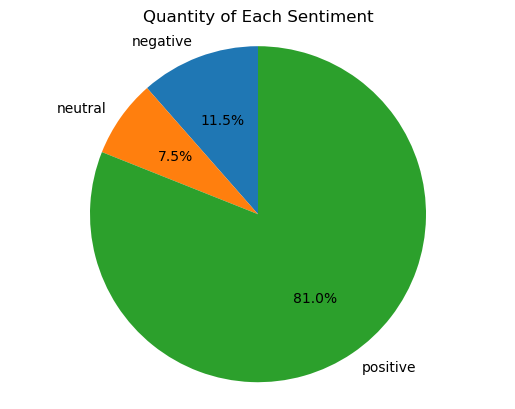

sentiment
positive     5460975
negative      773834
neutral       504781
Name: count, dtype: int64

In [32]:
import matplotlib
import matplotlib.pyplot as plt

# Bracket the sentiments based on Overall value
df['sentiment'] = pd.cut(df['overall'], [0,2,3,5], labels=['negative','neutral','positive'])

# Group the data by sentiment for purposes of charting
sentiments = df.groupby(['sentiment'])

# Set the pie chart parameters
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', labeldistance=1.1, startangle=90)

plt.title("Quantity of Each Sentiment")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Get the exact count of each value to provide further information
df.value_counts(['sentiment'])

There is a significant misbalance of my classes, so I'm going to need to make sure I stratify the data so that the data is well represented. Before I do that, I'll tokenize the reviews and and prepare the data for splitting by narrowing down to fields of interest.

To get started with tokenizing, I need to know the max length I'll encounter in the reviews.

In [45]:
# Make the reviewText values string datatype. This is needed for tokenization.
# Also, since I'll be using a lower case BERT model, I'll make things lowercase.

df['str_reviewText'] = df['reviewText'].astype(str)
print(f"The longest review is {len(max(df['str_reviewText'], key=len))} characters")

The longest review is 33331 characters


In order for all the data going into the model to be same length, I'll need to zero-pad the sequences. For data consistency, I want all reviews to have some zero-padding. If my longest review length is 33,331 characters, I'll round up to 33,340 for my max length.

In [46]:
%%time
# Source: cs7324 lab 7
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_REVIEW_LEN = 500  # maximum and minimum number of words

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(df['str_reviewText'])
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(df['str_reviewText'])

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_REVIEW_LEN)
y = df_covid_reduced.Sentiment.values
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)
print(np.max(X))


Found 674507 unique tokens. Distilled to 674507 top words.


MemoryError: Unable to allocate 12.6 GiB for an array with shape (6739590, 500) and data type int32

In [ ]:
from sklearn.model_selection import train_test_split



In [34]:
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,sentiment
0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},D. C. Carrad,This is the best novel I have read in 2 or 3 y...,A star is born,937612800,NaN,positive
1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},Evy,"Pages and pages of introspection, in the style...",A stream of consciousness novel,1382486400,NaN,neutral
2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},Kcorn,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,NaN,positive
3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},Caf Girl Writes,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,968025600,NaN,positive
4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},W. Shane Schmidt,I was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,NaN,neutral


**explain how you performed this operation and why you think it is reasonable to split this particular dataset this way**

**For multi-task datasets, be sure to explain if it is appropriate to stratify within each task.**

**If the dataset is already split for you, explain how the split was achieved and how it is stratified.**

## [2.0 points] Train a model from scratch to perform the classification task (this does NOT need to be a transformer). 

**Verify the model converges (even if the model is overfit).**

#### Convolutional Neural Network 1 (CNN-1)

The first CNN I'll run will consist of 64 filters with a width of 5. I'm changing the filter size from the in-class example because my dataset is quite a bit smaller. So my thought being I won't need so many filters to get good results.

In [ ]:
if False:
    # Source: Modified from in-class lecture, cs7324, notebook 13a
    from tensorflow.keras.metrics import Precision

    EMBED_SIZE = 50  # same size as loaded from GLOVE
    NUM_CLASSES = 3
    sequence_input = Input(shape=(MAX_TWEET_LEN,), dtype='int32')
    # starting size: 500
    embedded_sequences = embedding_layer(sequence_input) # from previous embedding
    x = Conv1D(64, 5, activation='relu',
            kernel_initializer='he_uniform')(embedded_sequences)

    # after conv, size becomes: 500-4=496
    x = MaxPooling1D(5)(x) # after max pool, 996/5 = 99
    x = Dropout(0.2)(x) # after dropout, size is 95
    x = Conv1D(64, 5, activation='relu',
            kernel_initializer='he_uniform')(x)

    # new size is 195
    x = MaxPooling1D(5)(x) # after max pool, size is 95/5 = 19
    x = Dropout(0.2)(x)
    x = Conv1D(64, 5, activation='relu',
            kernel_initializer='he_uniform')(x)

    # after convolution, size becomes 15 elements long
    x = MaxPooling1D(5)(x) # this is the size to globally flatten, 15/5 = 3
    # flattened vector max pools across each of the 3 elements
    # so vectors is now 192 dimensions 3*64 = 192
    x = Flatten()(x)

    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu',
            kernel_initializer='he_uniform')(x)

    preds = Dense(NUM_CLASSES, activation='softmax',
                kernel_initializer='glorot_uniform')(x)

    model_cnn_1 = Model(sequence_input, preds)

    # if representing as OHE, use categorical_crossentropy
    # if representing the class as an integer, use sparse_categorical_crossentropy
    model_cnn_1.compile(loss='categorical_crossentropy', 
                optimizer='rmsprop',
                metrics=['Precision'])

    print(model_cnn_1.summary())

    cnn1_histories = []
    tmp = model_cnn_1.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
            epochs=30, batch_size=128)
    cnn1_histories.append(tmp)

## [2.0 points] Transfer Learning

In [ ]:
%time
from transformers import BertTokenizer, TFBertModel

CPU times: total: 0 ns
Wall time: 0 ns


**Train a model by transfer learning from your foundational model.**

**Verify that the new model converges. You only need to train a model using the bottleneck features for this step.**

## [2.0 points] Fine Tuning

**Perform fine tuning upon the model by training some layers within the foundational model**

**Verify that the model converges.**

## [4.0 points] Report the results

**Report the results of all models using the evaluation procedure that you argued for at the beginning of the lab.**

**Compare the convergence of the models and the running time.**

**Results should be reported with proper statistical comparisons and proper visualizations.**

## Sources

In [ ]:
https://keras.io/examples/nlp/pretraining_BERT/
https://www.smashwords.com/about
https://huggingface.co/google-bert/bert-base-uncased?text=The+goal+of+a+dog%27s+life+is+%5BMASK%5D.
https://keras.io/guides/keras_nlp/transformer_pretraining/
https://huggingface.co/transformers/v3.3.1/pretrained_models.html
https://www.analyticsvidhya.com/blog/2021/05/all-you-need-to-know-about-bert/#:~:text=The%20BERTBase%20model%20uses,has%20around%20110M%20trainable%20parameters.